In [3]:
# Lib Imports
import pandas as pd
import pickle
import unidecode,re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# Data Import
fsys="/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/tweets/lampos_dataset/"
data_tweets=pd.read_csv(fsys+"all_lampos_users.csv",error_bad_lines=False,header=0,sep=";")
data_income=pd.read_csv(fsys+"income_dataset/users-income",header=0,sep=" ")

usr_text=(data_tweets.dropna(how="any").drop(["tweet_id","tweet_date"],axis=1).groupby(
    'user_id',squeeze=True,)['tweet_text'].apply(lambda x: "%s" % ' '.join(x))).to_frame()
usr_text.reset_index(inplace=True)
nbt=(data_tweets.dropna(how="any").drop(["tweet_id","tweet_date"],axis=1).groupby(
    'user_id',squeeze=True,)['tweet_text'].apply(lambda x: len(x))).to_frame().values
usr_text["nb_tweets"]=[y[0] for y in nbt]
data_lampos=pd.merge(usr_text,data_income,on="user_id")


#N-Gram vectorizer
french_stopwords = list(set(stopwords.words('french')))
eng_stopwords = list(set(stopwords.words('english')))

#Tweet Information: N-grams
n_grams_tweet_vect=CountVectorizer(stop_words=french_stopwords+eng_stopwords,
                                 max_features=1000,ngram_range=(1,2),
                                lowercase=True)

mat_n_grams_tweet=n_grams_tweet_vect.fit_transform(list(data_lampos.tweet_text.values)).todense()


#Tweet Information: Topics
#import numpy as np
#mat_topics_tweet=np.vstack([np.hstack(sample.as_matrix()).reshape((1,100))
#                            for it,sample in (usr_text[["cfd_100",]].iterrows())])

# All non-SES info
data_matrix=mat_n_grams_tweet#np.hstack([mat_n_grams_tweet,mat_topics_tweet])

# Final Synthesis
data_lampos["fts"]=[row for row in data_matrix.tolist()]

# Feature and Target Set preparation
min_val=100
ses_text_insee=data_lampos[data_lampos.nb_tweets>min_val]
import numpy as np
mat_info=np.vstack([np.hstack(sample.as_matrix()).reshape((1,len(ses_text_insee.iloc[0]["fts"])))
                            for it,sample in (ses_text_insee[["fts",]].iterrows())])


__SEE IF IMPROVEMENT WITH TOPIC VECTOR TO ASSESS SANITY OF CFD FUNCITION__

In [4]:
data_lampos.head()

,user_id,tweet_text,nb_tweets,mean_income,fts
0,1103,trendy i want to quit email it sucks why was 1...,1610,40848,"[5, 8, 13, 7, 19, 11, 5, 3, 3, 3, 0, 0, 1, 9, ..."
1,8273,trash can tile reflection even tho i m a stron...,2570,42800,"[2, 4, 21, 5, 3, 9, 3, 6, 9, 5, 3, 2, 1, 6, 0,..."
2,9269,congrats on joining lots of smart folks there ...,1140,40848,"[0, 12, 14, 7, 2, 5, 2, 0, 4, 0, 1, 7, 3, 4, 1..."
3,10571,done at what point is a 1 hr 45 min phone call...,1647,10325,"[2, 3, 17, 1, 2, 4, 1, 1, 4, 0, 1, 1, 3, 0, 0,..."
4,12496,there are definitely worse places to have a me...,2224,18986,"[0, 0, 8, 6, 6, 2, 2, 2, 4, 3, 2, 3, 0, 5, 0, ..."


In [5]:
# Final Preprocessing
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(mat_info)
medin=np.median(ses_text_insee.mean_income[~np.isnan(ses_text_insee.mean_income)])
ses_iris_class_try=np.array(ses_text_insee.mean_income>medin).astype(np.int)# 2 class

/home/jlevyabi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [10]:
# Prediction of SES from Ling Fts
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", 
         "Random Forest", "Neural Net", "AdaBoost"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier()]

X_train, X_test, y_train, y_test = train_test_split(X, ses_iris_class_try,test_size=.2, random_state=42)
clf_arrs=[]
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    clf_arrs.append(clf)
    score = clf.score(X_test, y_test)
    print ("2-Classification accuracy for %s:  %f"%(name,score))

2-Classification accuracy for Nearest Neighbors:  0.642140
2-Classification accuracy for Linear SVM:  0.668896
2-Classification accuracy for RBF SVM:  0.498328
2-Classification accuracy for Random Forest:  0.637124
2-Classification accuracy for Neural Net:  0.673913
2-Classification accuracy for AdaBoost:  0.715719


In [11]:
print(classification_report(y_test,clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.70      0.76      0.73       298
          1       0.74      0.67      0.70       300

avg / total       0.72      0.72      0.72       598



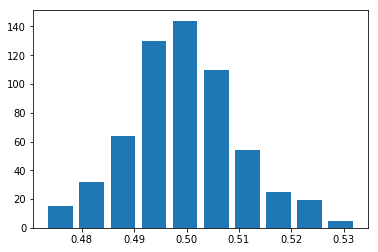

In [13]:
best_clf=-1
import matplotlib.pyplot as plt
plt.hist(clf_arrs[best_clf].predict_proba(X_test)[:,1],rwidth=0.8);

In [ ]:
clf_arrs.

In [40]:
import sys
from termcolor import colored, cprint

text = colored('Hello, World!', 'red', attrs=['reverse', 'blink'])
print(text)
cprint('Hello, World!', 'green', 'on_red')

print_red_on_cyan = lambda x: cprint(x, 'red', 'on_cyan')
print_red_on_cyan('Hello, World!')
print_red_on_cyan('Hello, Universe!')

for i in range(10):
    cprint(i, 'magenta', end=' ')

cprint("Attention!", 'red', attrs=['bold'], file=sys.stderr)

Hello, World!
Hello, World!
Hello, World!
Hello, Universe!
0 1 2 3 4 5 6 7 8 9 

Attention!


In [45]:
text.format()

'\x1b\x1b\x1bHello, World!\x1b'

In [42]:
colored?

48


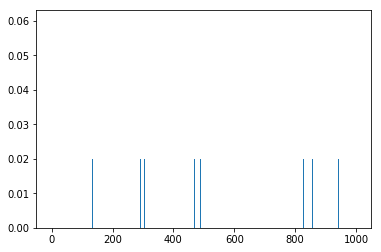

In [18]:
plt.bar(range(len(clf_arrs[best_clf].feature_importances_)),clf_arrs[best_clf].feature_importances_);
print(np.sum(clf_arrs[best_clf].feature_importances_>0))

In [38]:
print([list(n_grams_tweet_vect.vocabulary_.keys())[x] 
       for x in np.where(clf_arrs[best_clf].feature_importances_>0)[0].tolist()])

['want', 'days', 'services', 'talk', 'may', 'question', 'facebook', 'money', 'president', 'government', 'need', 'wanted', 'saying', '100', 'family', 'okay', 'felt', 'dead', 'end', 'court', 'episode', 'called', 'fight', 'chicken', 'hi', 'bit', 'busy', '50', 'true', 'birthday', 'cheers', 'woman', 'air', 'vote', 'automatically', 'trip', 'weather', 'lol', 'heard', 'star', 'met', 'eye', 'cant', 'college', 'act', 'mr', '2016', 'giveaway']
